In [6]:
import pandas as pd

from visualization.utils import plot_trend_labels
from returns_estimation import ReturnsEstimatorWithFees
from optimization import Optimizer
from returns_estimation.fees_config import FeesConfig
from trend_labelling import OracleTernaryTrendLabeller
from optimization.optimization_bounds import OptimizationBounds

We will need an utility to plot a parameter grid.

In [17]:
#Utility to plot a parameter grid
from itertools import product

from matplotlib import pyplot as plt
from trend_labelling.label_scaling import Labels


def _plot_labeller_base(labeller_class, time_series: list[float], grid_shape: tuple[int,int], figsize: tuple[int,int], param_sets: list[dict]) -> None:
    """
    Base plotting function for labeller parameter visualization.
    
    Args:
        labeller_class: The labeller class to instantiate
        time_series: List of price values to label
        grid_shape: Tuple of (rows, cols) for the plot grid
        figsize: Tuple of figure dimensions
        param_sets: List of parameter dictionaries to use for labelling
    """
    # Create figure and axes grid
    fig, axes = plt.subplots(*grid_shape, figsize=figsize)
    plt.subplots_adjust(hspace=0.2, wspace=0.1)
    axes_flat = axes.T.flatten()
    
    # Create plots for each parameter set
    for idx, params in enumerate(param_sets):
        if idx >= len(axes_flat):
            break
            
        # Instantiate labeller with current parameters and get labels
        labeller = labeller_class(**params)
        labels = labeller.get_labels(time_series)
        
        # Plot on current subplot
        ax = axes_flat[idx]
        ax.plot(time_series, color='black', linewidth=1)
        
        # Color background based on labels
        for t in range(len(time_series)):
            if labels[t] == Labels.UP:  # Uptrend
                ax.axvspan(t, t+1, color="darkgreen", alpha=0.3)
            elif labels[t] == Labels.DOWN:  # Downtrend
                ax.axvspan(t, t+1, color="brown", alpha=0.3)
            elif labels[t] == Labels.NEUTRAL:  # Neutral trend (for ternary labellers)
                ax.axvspan(t, t+1, color="white", alpha=0.2)
        
        # Format title with parameter values        
        title = ", ".join(f"{k}={v}" for k,v in params.items())
        ax.set_title(title, fontsize=10)
        ax.grid(True)
        ax.tick_params(axis='both', which='major', labelsize=8)

    plt.show()

def plot_parameter_grid(labeller_class, time_series: list[float], param_grid: dict, grid_shape: tuple[int,int]=(3,3), figsize: tuple[int,int]=(15,15)) -> None:
    """
    Plot a grid of trend labels for different parameter combinations.
    
    Args:
        labeller_class: The labeller class to instantiate
        time_series: List of price values to label
        param_grid: Dict mapping parameter names to lists of values to try
        grid_shape: Tuple of (rows, cols) for the plot grid
        figsize: Tuple of figure dimensions
    """
    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    param_sets = [dict(zip(param_names, combo)) for combo in product(*param_values)]
    
    _plot_labeller_base(labeller_class, time_series, grid_shape, figsize, param_sets)



Let's import the data.

In [12]:
time_series = pd.read_csv("../tests/data/closing_prices.csv", header=None).iloc[:,0].tolist()

# Optimizing the Ternary Oracle labeller

Let's optimize the Ternary Oracle labeller, which being a multiparameter labeller, will be slightly more complex.
We can start by recycling the parameter grid from the catalogue notebook and visually screen the parameter space.

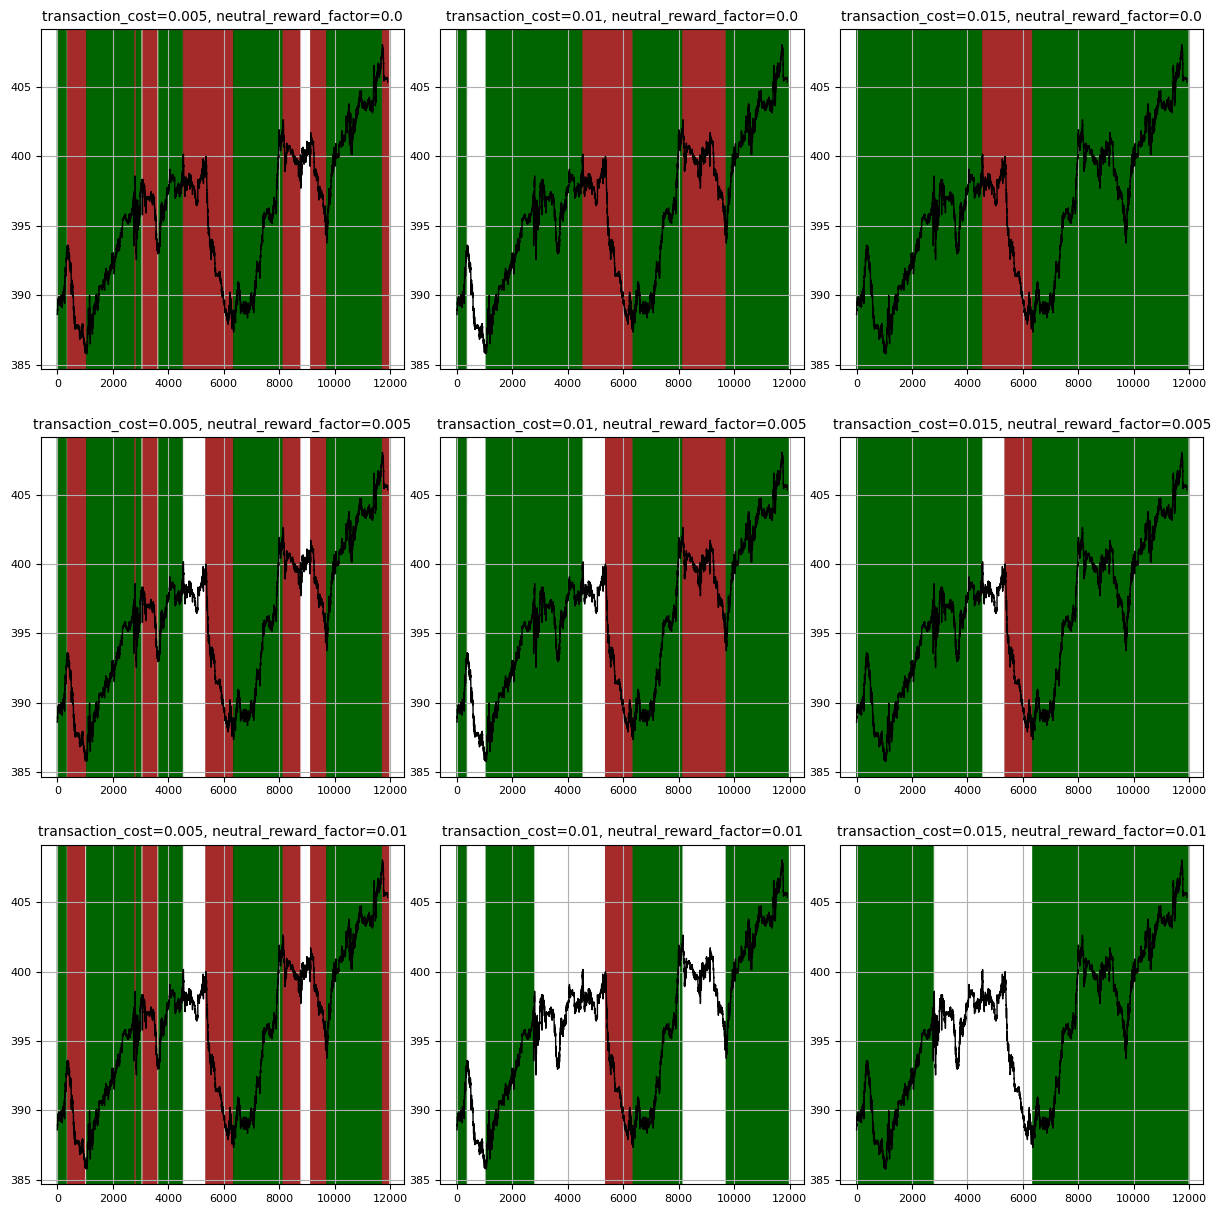

In [28]:
param_grid = {
    'transaction_cost': [0.005, 0.01, 0.015],
    'neutral_reward_factor': [0.0, 0.005, 0.01]
}
plot_parameter_grid(OracleTernaryTrendLabeller, time_series, param_grid)


In [7]:
print(f"The default bounds for the Ternary Oracle labeller are {OptimizationBounds().get_bounds(OracleTernaryTrendLabeller)}")

The default bounds for the Ternary Oracle labeller are {'transaction_cost': (0.0, 0.01), 'neutral_reward_factor': (0.0, 0.1)}


We might fall short on the bounded region so let's try to expand the bounds.

In [8]:
custom_bounds = {
    'transaction_cost': (0.001, 0.03), # Increased from 0.01 to 0.03
    'neutral_reward_factor': (0.0, 0.1) # Left bound unchanged
}


Let's define the fees configuration. We can for instance:
- Have an iso transaction fee between the long and short positions.
- Introduce a holding fee for both positions, trying to get the labeller to identify neutral trends as well.

In [24]:
fees_config = FeesConfig(
    lp_transaction_fees=0.01,
    sp_transaction_fees=0.01,
    lp_holding_fees=0.003,
    sp_holding_fees=0.003
)

Let's run the optimization, we can set verbose 1 to get information about each optimum found.

In [30]:

opt = Optimizer(ReturnsEstimatorWithFees(fees_config), initial_points=10, nb_iter=50)
optimization_results = opt.optimize(OracleTernaryTrendLabeller, time_series, custom_bounds, verbose=1)


|   iter    |  target   | neutra... | transa... |
-------------------------------------------------
| 3         | 7.65      | 0.02482   | 0.01386   |
| 5         | 25.29     | 0.01371   | 0.006291  |


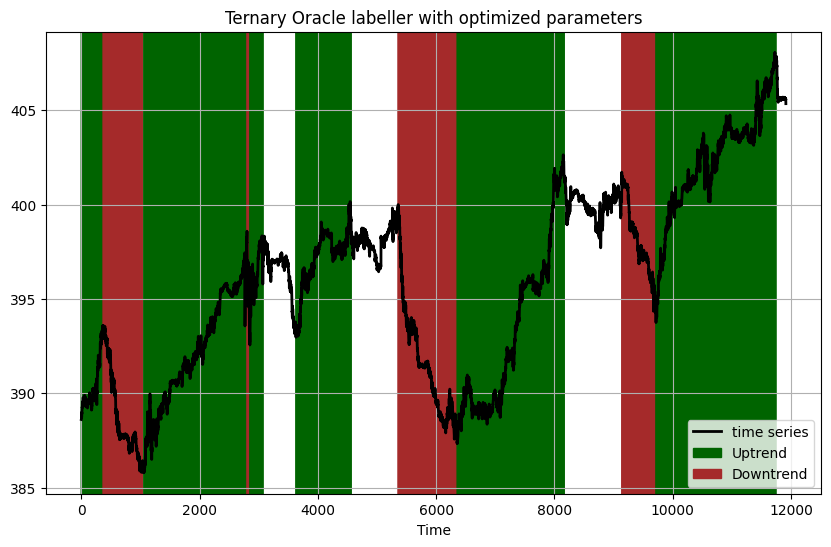

In [38]:
labeller = OracleTernaryTrendLabeller(**optimization_results['params'])
labels = labeller.get_labels(time_series)
plot_trend_labels(time_series, labels, title=f"Ternary Oracle labeller with optimized parameters")

Lower transaction fees would lead to a more volatile labelling, best fitted to short term trends.
Lower or null holding fees would lead the labeller to be more prune to identify long-short trends over neutral trends

# About the validity of the parameters

## Time series with a different relative change rate

One important thing to note is that the parameters found are valid for the time series used in the optimization and time series with a similar relative change rate, i.e. the average delta between contiguous points is similar.

We can visually check the validity of the parameters by plotting the labels for the **same** time series after substracting the minimum value from all points. 

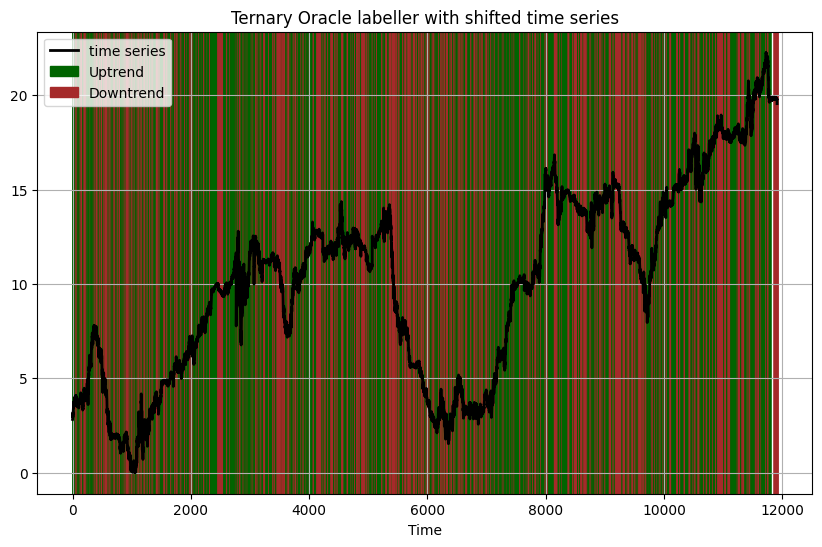

In [39]:
time_series_shifted = [x - min(time_series) for x in time_series]
plot_trend_labels(time_series_shifted, labeller.get_labels(time_series_shifted), title=f"Ternary Oracle labeller with shifted time series")

Since the relative delta has highly increased, the nsaction_cost is now desproportionally low, leading to a too volatile labelling.

## Negative time series

Another issue would arise if the time series is negative. Since the labellers are based on price differences, they would usually all be labelled as downtrends.

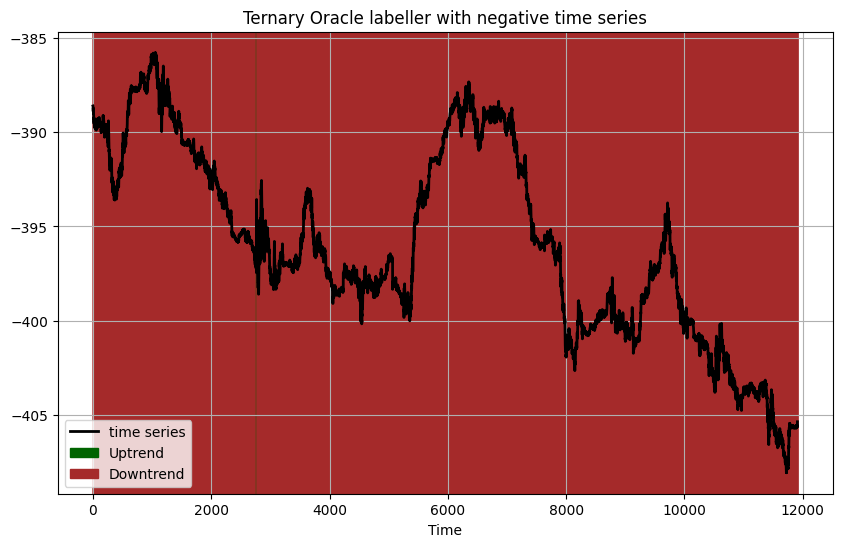

In [40]:
negative_time_series = [-x for x in time_series]
plot_trend_labels(negative_time_series, labeller.get_labels(negative_time_series), title=f"Ternary Oracle labeller with negative time series")

Labellers can still be fitted, but the bounds should be adjusted to include negative values.

In [44]:
NEGATIVE_TRANSACTION_COST = -0.0075

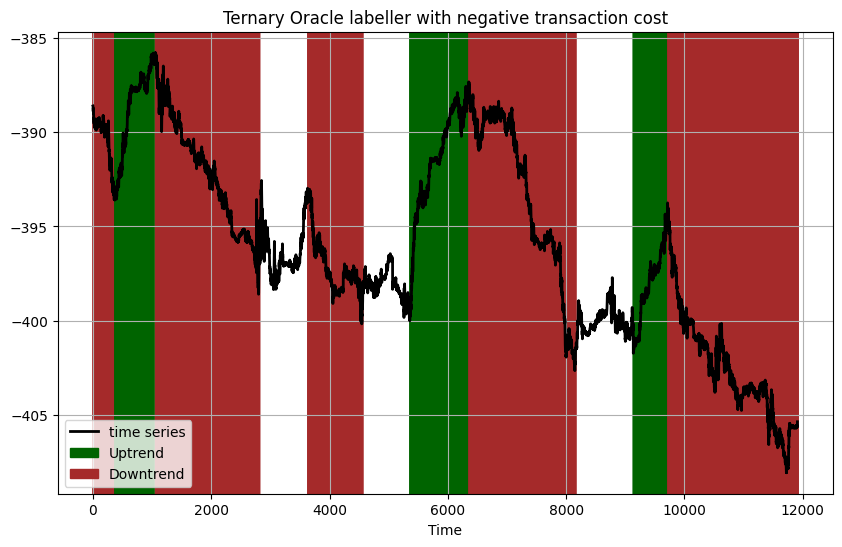

In [45]:

labeller = OracleTernaryTrendLabeller(transaction_cost=NEGATIVE_TRANSACTION_COST, neutral_reward_factor=0.01)
labels = labeller.get_labels(negative_time_series)
plot_trend_labels(negative_time_series, labels, title=f"Ternary Oracle labeller with negative transaction cost")